    
**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных


##  Знакомство с данными, базовый анализ и расширение данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [159]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435



**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах



Для начала посмотрим на временные рамки


In [160]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].describe()[-2:]

C:\Users\xxsan\AppData\Local\Temp\ipykernel_8024\2742804585.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  taxi_data['pickup_datetime'].describe()[-2:]


first    2016-01-01 00:00:17
last     2016-06-30 23:59:39
Name: pickup_datetime, dtype: object


Посмотрим на пропуски. 


In [161]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB



Посмотрим на статистические характеристики некоторых признаков. 



In [162]:
print(taxi_data.describe())
print(taxi_data.describe(include=object))

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01

Разделим временной признак

In [163]:
def add_datetime_features(data):
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_name()
    return data

add_datetime_features(taxi_data)
print('Saturday trips =',  taxi_data[taxi_data['pickup_day_of_week'] == 'Saturday']['id'].count())
print('Mean trips per day =', round(taxi_data['pickup_date'].value_counts().mean()))

Saturday trips = 220868
Mean trips per day = 8015


Добавим признак выходного дня


In [164]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data['date'] = (pd.to_datetime(holiday_data['date'],format='%Y-%m-%d %H:%M:%S')).dt.date
def add_holiday_features(trip_data, holiday_data):
    df = trip_data.merge(holiday_data['date'], how='left', left_on='pickup_date', right_on = 'date')
    df['pickup_holiday'] = df['date'].apply(lambda x: 0 if x is np.NaN else 1)
    df = df.drop('date', axis=1)
    return df
taxi_data = add_holiday_features(taxi_data, holiday_data)

np.median(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'])

585.0

Добавим в основную таблицу данные из OSRM API
* total_distance;
* total_travel_time;
* number_of_steps.


In [165]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
def add_osrm_features(trip_data, osrm_data):
    df = trip_data.merge(osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], on='id', how='left')
    return df
taxi_data = add_osrm_features(taxi_data, osrm_data)

print(round(taxi_data.describe()['trip_duration']['50%'] - taxi_data.describe()['total_travel_time']['50%']))
print(taxi_data.isnull().sum())

372
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64


In [166]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [167]:
def add_geographical_features(data):
    data['haversine_distance'] = get_haversine_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    data['direction'] = get_angle_direction(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    return data

taxi_data = add_geographical_features(taxi_data)

round(np.median(taxi_data['haversine_distance']),2)

2.09

Добавил кластеры на основе местоположения


In [168]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(data, kmeans):
    data['geo_cluster'] = kmeans.predict(np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                                                    data[['dropoff_latitude', 'dropoff_longitude']])))
    return data
taxi_data = add_cluster_features(taxi_data, kmeans)

taxi_data['geo_cluster'].value_counts()

0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

Добавим характеристики погоды 
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.



In [169]:
weather_data = pd.read_csv('data/weather_data.csv')
weather_data['date'] = (pd.to_datetime(weather_data['time'])).dt.date
weather_data['hour'] = (pd.to_datetime(weather_data['time'])).dt.hour

def add_weather_features(taxi_data, weather_data):
    df = taxi_data.merge(weather_data[['temperature','visibility','wind speed','precip','events','date','hour']], how='left', left_on=['pickup_date','pickup_hour'], right_on=['date','hour'])
    df = df.drop(['date','hour'], axis=1)
    return df

taxi_data = add_weather_features(taxi_data, weather_data)

print(taxi_data[taxi_data['events'] == 'Snow']['id'].count())
np.round(taxi_data.isnull().mean()*100,3)

13126


id                    0.000
vendor_id             0.000
pickup_datetime       0.000
dropoff_datetime      0.000
passenger_count       0.000
pickup_longitude      0.000
pickup_latitude       0.000
dropoff_longitude     0.000
dropoff_latitude      0.000
store_and_fwd_flag    0.000
trip_duration         0.000
pickup_date           0.000
pickup_hour           0.000
pickup_day_of_week    0.000
pickup_holiday        0.000
total_distance        0.000
total_travel_time     0.000
number_of_steps       0.000
haversine_distance    0.000
direction             0.000
geo_cluster           0.000
temperature           0.825
visibility            0.825
wind speed            0.825
precip                0.825
events                0.825
dtype: float64

Заполним пропуски по погоде


In [170]:
def clear_null_data(data):
    weather_conditions = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_conditions:
        data[col] = data[col].fillna(
        data.groupby('pickup_date')[col].transform('median'))
        
    data['events'] = data['events'].fillna('None')
    
    data = data.fillna({'total_distance':data['total_distance'].median(),
                        'total_travel_time':data['total_travel_time'].median(),
                        'number_of_steps':data['number_of_steps'].median()})
    return data


taxi_data = clear_null_data(taxi_data)


taxi_data['temperature'].median()

11.1

Рассмотрим распределение по средней скорости поездки

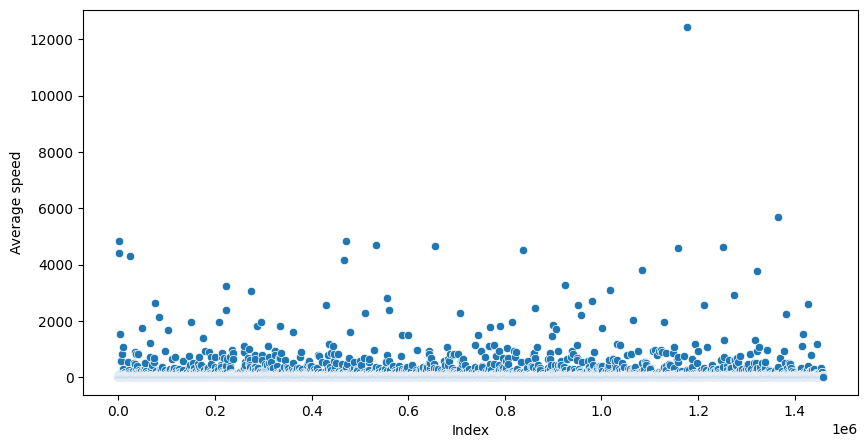

In [171]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Удалим поездки со средней коростью выше 300 и длительностью более суток

In [172]:
def outliers(data):
    dur_mask = data['trip_duration'] > 86400
    out_duration = data[dur_mask]
    speed_mask = (data['total_distance'] / data['trip_duration'] * 3.6) > 300
    out_speed = data[speed_mask]
    all_out = data[speed_mask | dur_mask]
    cleaned = data.drop(list(all_out.index))
    return out_duration, out_speed, cleaned

out_duration, out_speed, taxi_data = outliers(taxi_data)

print(out_duration.shape[0])
print(out_speed.shape[0])
print(taxi_data.shape[0])

4
407
1458233


## Разведывательный анализ данных 

In [173]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

p=0.00
Данные не распределены нормально


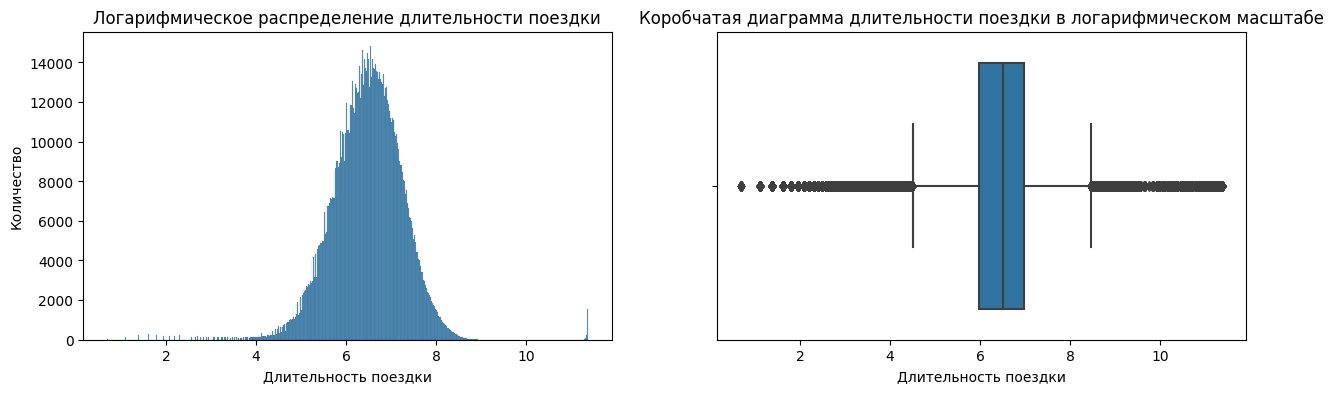

In [174]:
fig , ax = plt.subplots(ncols=2, nrows=1, figsize=(15,4))
histplot = sns.histplot(data=taxi_data, x='trip_duration_log', ax=ax[0])
histplot.set_title('Логарифмическое распределение длительности поездки')
histplot.set_xlabel('Длительность поездки')
histplot.set_ylabel('Количество')
boxplot = sns.boxplot(data=taxi_data, x='trip_duration_log', ax=ax[1])
boxplot.set_title('Коробчатая диаграмма длительности поездки в логарифмическом масштабе')
boxplot.set_xlabel('Длительность поездки');

from scipy.stats import normaltest
alpha = 0.05
_, p = normaltest(taxi_data['trip_duration_log'])
print('p=%.2f' % p)

if p > alpha/2:
	print('Данные распределены нормально')
else:
	print('Данные не распределены нормально')

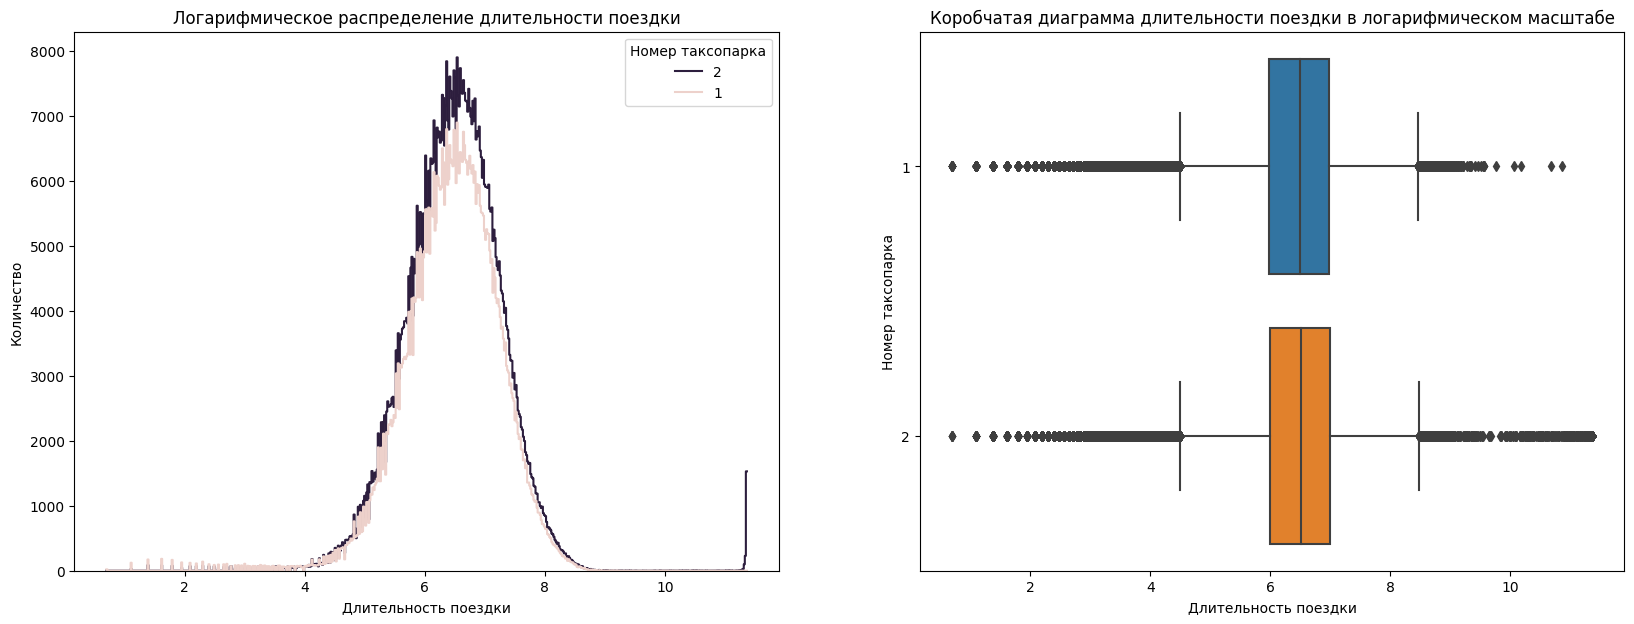

In [175]:
fig , ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))
histplot = sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', ax=ax[0], fill=False,element="step")
histplot.set_title('Логарифмическое распределение длительности поездки')
histplot.set_xlabel('Длительность поездки')
histplot.set_ylabel('Количество')
histplot.legend(title='Номер таксопарка', labels=['2','1'])

boxplot = sns.boxplot(data=taxi_data, x='trip_duration_log',y='vendor_id', ax=ax[1], orient='h')
boxplot.set_title('Коробчатая диаграмма длительности поездки в логарифмическом масштабе')
boxplot.set_xlabel('Длительность поездки')
boxplot.set_ylabel('Номер таксопарка');

Text(0, 0.5, 'Количество')

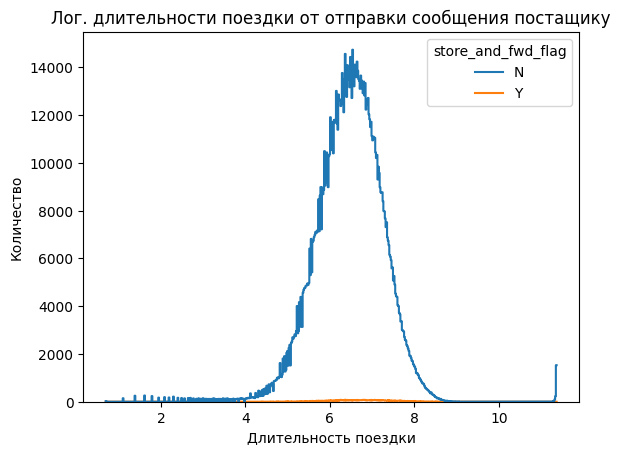

In [176]:
histplot = sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag',fill=False,element="step")
histplot.set_title('Лог. длительности поездки от отправки сообщения постащику')
histplot.set_xlabel('Длительность поездки')
histplot.set_ylabel('Количество')

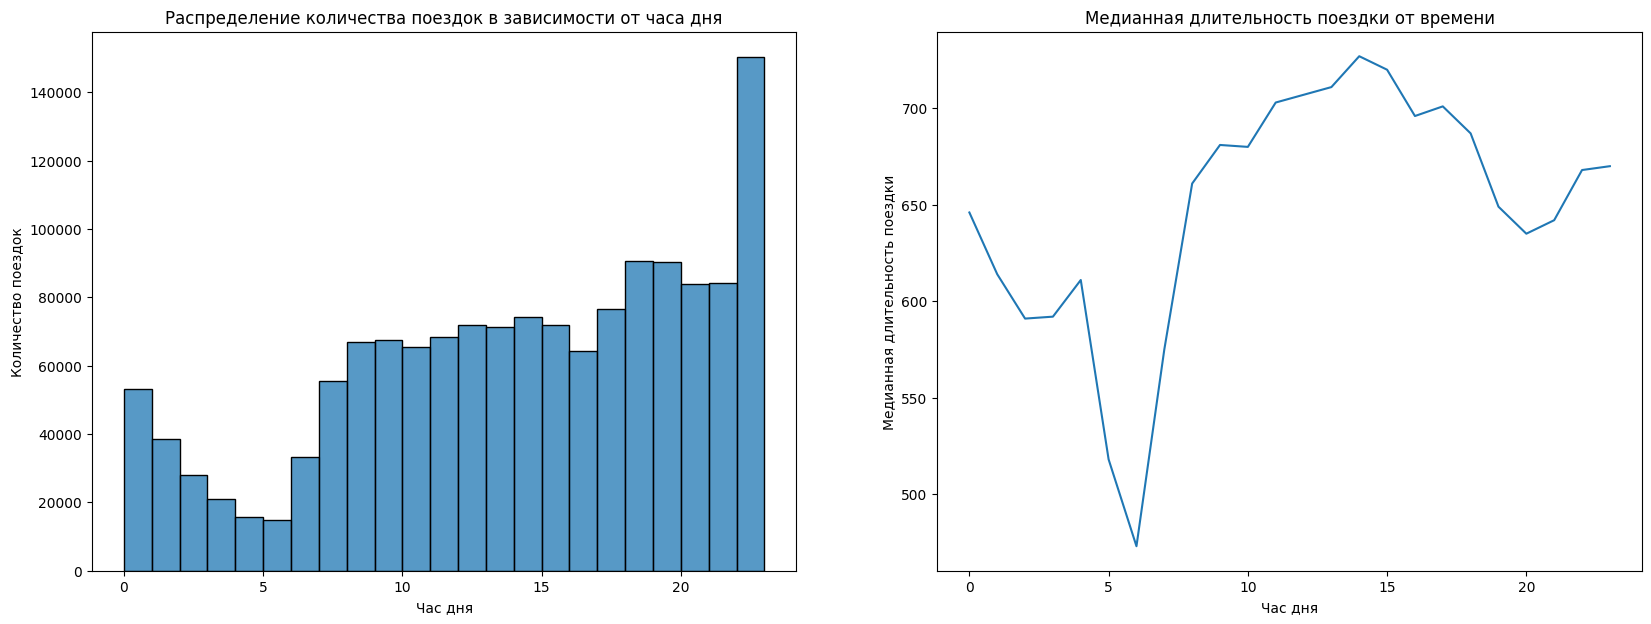

In [177]:
dur_drouper_by_hour = taxi_data.groupby('pickup_hour')['trip_duration'].median()
fig , ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))
histplot1 = sns.histplot(data=taxi_data, x='pickup_hour', ax=ax[0], binwidth=1)
histplot1.set_title('Распределение количества поездок в зависимости от часа дня')
histplot1.set_xlabel('Час дня')
histplot1.set_ylabel('Количество поездок')
histplot2 = sns.lineplot(data=dur_drouper_by_hour,ax=ax[1])
histplot2.set_title('Медианная длительность поездки от времени')
histplot2.set_xlabel('Час дня')
histplot2.set_ylabel('Медианная длительность поездки');

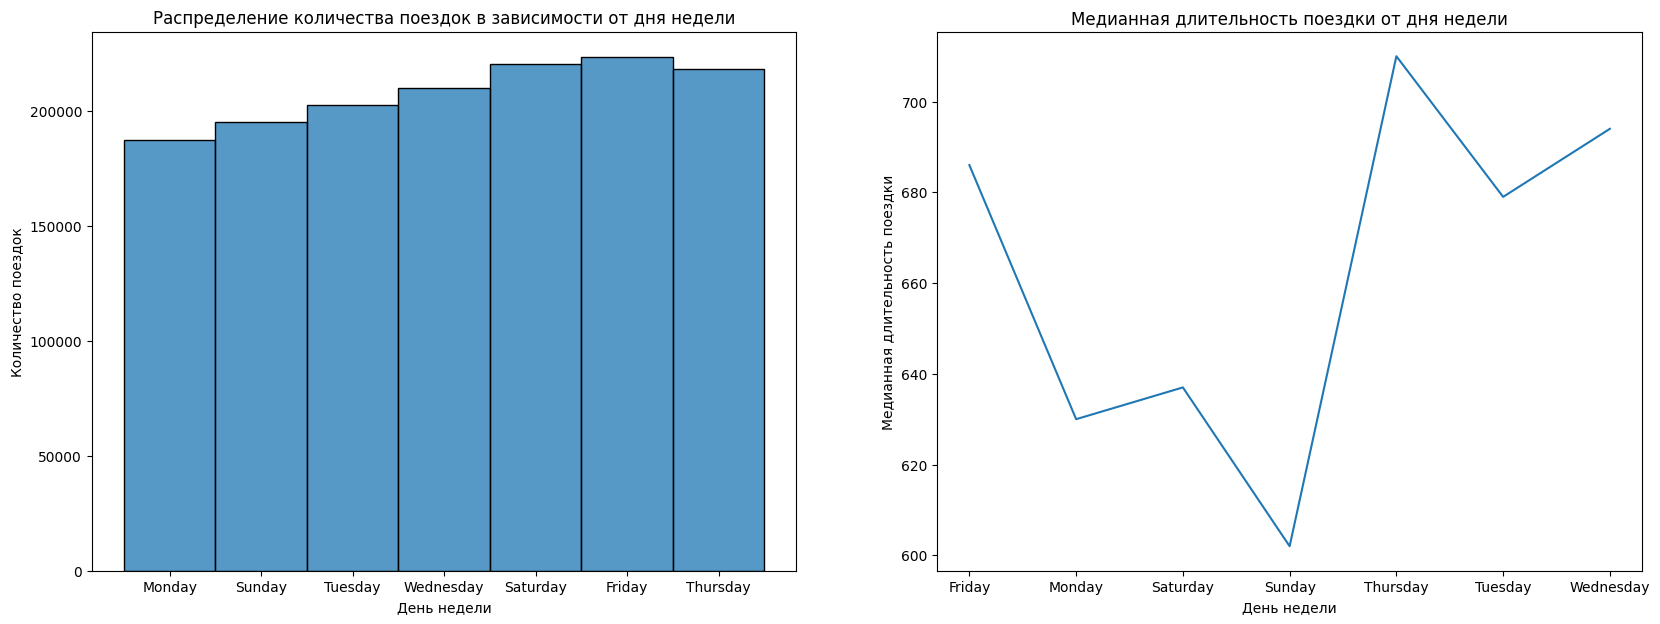

In [178]:
dur_drouper_by_day = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()
fig , ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))
histplot1 = sns.histplot(data=taxi_data, x='pickup_day_of_week', ax=ax[0])
histplot1.set_title('Распределение количества поездок в зависимости от дня недели')
histplot1.set_xlabel('День недели')
histplot1.set_ylabel('Количество поездок')
histplot2 = sns.lineplot(data=dur_drouper_by_day,ax=ax[1])
histplot2.set_title('Медианная длительность поездки от дня недели')
histplot2.set_xlabel('День недели')
histplot2.set_ylabel('Медианная длительность поездки');

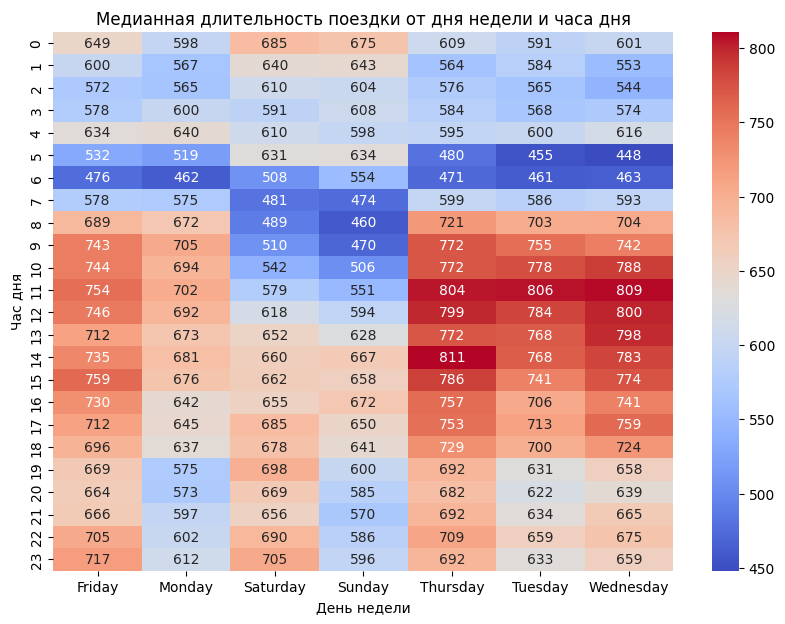

In [179]:
pivot = taxi_data.pivot_table(values='trip_duration',
                              index='pickup_hour',
                              columns='pickup_day_of_week',
                              aggfunc='median')
fig, ax = plt.subplots(figsize=(10, 7))
heat = sns.heatmap(data=pivot, cmap='coolwarm',annot=True, fmt='.0f')
heat.set_title('Медианная длительность поездки от дня недели и часа дня')
heat.set_xlabel('День недели')
heat.set_ylabel('Час дня');

c:\Users\xxsan\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\xxsan\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


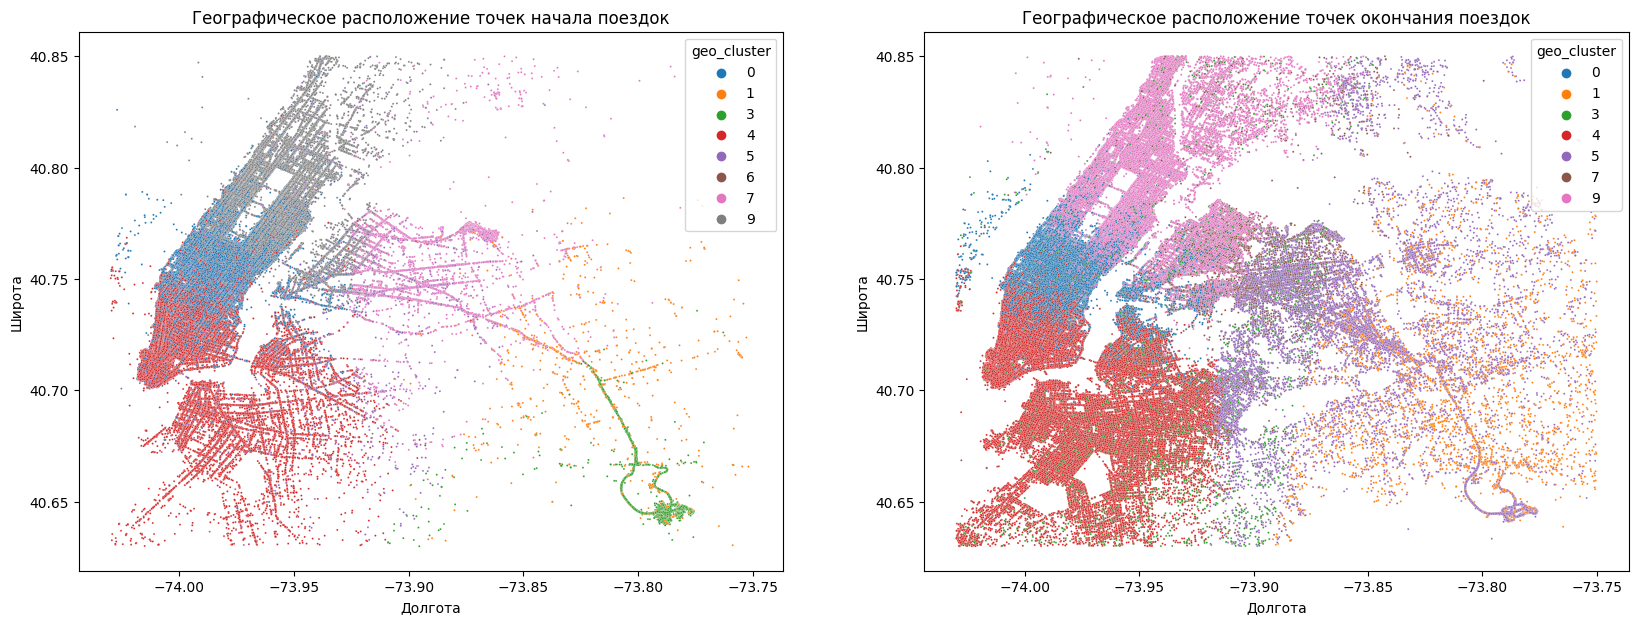

In [180]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

city_border_pick = taxi_data[  (taxi_data['pickup_longitude'] >= city_long_border[0])
                        & (taxi_data['pickup_longitude'] <= city_long_border[1])
                        & (taxi_data['pickup_latitude'] >= city_lat_border[0])
                        & (taxi_data['pickup_latitude'] <= city_lat_border[1]) ]

city_border_drop = taxi_data[  (taxi_data['dropoff_longitude'] >= city_long_border[0])
                        & (taxi_data['dropoff_longitude'] <= city_long_border[1])
                        & (taxi_data['dropoff_latitude'] >= city_lat_border[0])
                        & (taxi_data['dropoff_latitude'] <= city_lat_border[1]) ]

fig , ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))
scatterplot1 = sns.scatterplot(data=city_border_pick, x='pickup_longitude', y='pickup_latitude', hue='geo_cluster', ax=ax[0], s=2, palette='tab10')
scatterplot1.set_title('Географическое расположение точек начала поездок')
scatterplot1.set_xlabel('Долгота')
scatterplot1.set_ylabel('Широта')
scatterplot2 = sns.scatterplot(data=city_border_drop, x='dropoff_longitude', y='dropoff_latitude',  hue='geo_cluster',ax=ax[1],  s=2, palette='tab10')
scatterplot2.set_title('Географическое расположение точек окончания поездок')
scatterplot2.set_xlabel('Долгота')
scatterplot2.set_ylabel('Широта');

## Отбор и преобразование признаков

In [181]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


In [182]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


In [183]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


In [184]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


In [185]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print('Среднее по столбцу vendor_id:  {:.2f}'.format(train_data['vendor_id'].mean()))
print('Среднее по столбцу store_and_fwd_flag:  {:.3f}'.format(train_data['store_and_fwd_flag'].mean()))

Среднее по столбцу vendor_id:  0.53
Среднее по столбцу store_and_fwd_flag:  0.006


In [186]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster' , 'events']
one_hot_encoder = preprocessing.OneHotEncoder(drop='first')
train_data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
train_data_onehot = pd.DataFrame(train_data_onehot, columns=column_names)

Добавим полученную таблицу с закодированными признаками:

In [187]:
# train_data = data_onehot
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), train_data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


In [188]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

In [189]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

In [190]:
selectKB = feature_selection.SelectKBest(feature_selection.f_regression , k=25)
selectKB.fit(X_train, y_train_log)
best_features = selectKB.get_feature_names_out()

X_train, X_valid = X_train[best_features], X_valid[best_features]

масштабируем факторы 


In [191]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

X_valid_scaled_df = pd.DataFrame(X_valid_scaled)
print(round(X_valid_scaled_df[0].mean(), 2))

0.54


## линейная регрессия и деревья решений

In [192]:
ols = linear_model.LinearRegression()
ols.fit(X_train_scaled, y_train_log)
y_train_pred = ols.predict(X_train_scaled)
print('RMSLE train =',round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False),2))
y_valid_pred = ols.predict(X_valid_scaled)
print('RMSLE valid =',round(metrics.mean_squared_error(y_valid_log, y_valid_pred, squared=False),2))

RMSLE train = 0.54
RMSLE valid = 0.54


In [193]:
polynom = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
polynom.fit(X_train_scaled)
X_train_scaled_poly = polynom.transform(X_train_scaled)
X_valid_scaled_poly = polynom.transform(X_valid_scaled)
poly_ols = linear_model.LinearRegression()
poly_ols.fit(X_train_scaled_poly, y_train_log)
y_train_poly_pred = poly_ols.predict(X_train_scaled_poly)
print('RMSLE poly train =',round(metrics.mean_squared_error(y_train_log, y_train_poly_pred, squared=False),2))
y_valid_poly_pred = poly_ols.predict(X_valid_scaled_poly)
print('RMSLE poly valid =',round(metrics.mean_squared_error(y_valid_log, y_valid_poly_pred, squared=False),2))

RMSLE poly train = 0.47
RMSLE poly valid = 0.7


In [194]:
ridge_poly = linear_model.Ridge(alpha=1)
ridge_poly.fit(X_train_scaled_poly, y_train_log)
y_train_poly_pred = ridge_poly.predict(X_train_scaled_poly)
print('RMSLE poly train L2 =',round(metrics.mean_squared_error(y_train_log, y_train_poly_pred, squared=False),2))
y_valid_poly_pred = ridge_poly.predict(X_valid_scaled_poly)
print('RMSLE poly valid L2 =',round(metrics.mean_squared_error(y_valid_log, y_valid_poly_pred, squared=False),2))

RMSLE poly train L2 = 0.48
RMSLE poly valid L2 = 0.48


In [195]:
dtree = tree.DecisionTreeRegressor()
dtree.fit(X_train_scaled, y_train_log)
y_train_pred = dtree.predict(X_train_scaled)
print('RMSLE train =',round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False),2))
y_valid_pred = dtree.predict(X_valid_scaled)
print('RMSLE valid =',round(metrics.mean_squared_error(y_valid_log, y_valid_pred, squared=False),2))

RMSLE train = 0.0
RMSLE valid = 0.57


Depth = 7
RMSLE train = 0.44
RMSLE valid = 0.45
Depth = 8
RMSLE train = 0.44
RMSLE valid = 0.44
Depth = 9
RMSLE train = 0.43
RMSLE valid = 0.44
Depth = 10
RMSLE train = 0.42
RMSLE valid = 0.43
Depth = 11
RMSLE train = 0.41
RMSLE valid = 0.43
Depth = 12
RMSLE train = 0.41
RMSLE valid = 0.43
Depth = 13
RMSLE train = 0.4
RMSLE valid = 0.43
Depth = 14
RMSLE train = 0.38
RMSLE valid = 0.44
Depth = 15
RMSLE train = 0.37
RMSLE valid = 0.45
Depth = 16
RMSLE train = 0.36
RMSLE valid = 0.45
Depth = 17
RMSLE train = 0.34
RMSLE valid = 0.46
Depth = 18
RMSLE train = 0.32
RMSLE valid = 0.47
Depth = 19
RMSLE train = 0.3
RMSLE valid = 0.48


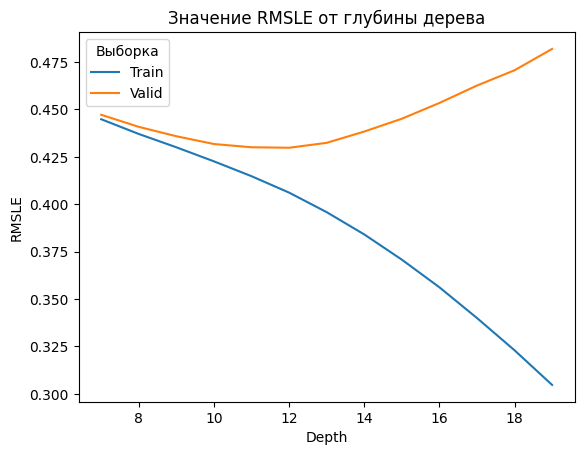

In [196]:
train_scores = []
valid_scores = []
depth = []

for i in range(7,20):
    dtree = tree.DecisionTreeRegressor(max_depth=i)
    dtree.fit(X_train_scaled, y_train_log)
    y_train_pred = dtree.predict(X_train_scaled)
    print('Depth =', i)
    depth.append(i)
    rmsle_train = metrics.mean_squared_error(y_train_log, y_train_pred, squared=False)
    print('RMSLE train =',round(rmsle_train,2))
    train_scores.append(rmsle_train)
    y_valid_pred = dtree.predict(X_valid_scaled)
    rmsle_valid = metrics.mean_squared_error(y_valid_log, y_valid_pred, squared=False)
    print('RMSLE valid =',round(rmsle_valid,2))
    valid_scores.append(rmsle_valid)
    
line = sns.lineplot(y=train_scores, x=depth)
line2 = sns.lineplot(y=valid_scores, x=depth) 
line.set_ylabel('RMSLE')
line.set_xlabel('Depth')
line.legend(title='Выборка', labels=['Train','Valid'])
line.set_title('Значение RMSLE от глубины дерева');

## ансамблевые методы и построение прогноза

In [197]:
rf = ensemble.RandomForestRegressor(n_estimators=200,
                                    max_depth=12,
                                    criterion='squared_error',
                                    min_samples_split=20,
                                    random_state=42,
                                    n_jobs=-1)
rf.fit(X_train_scaled, y_train_log)
y_train_pred = rf.predict(X_train_scaled)
print('RMSLE train =',round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False),2))
y_valid_pred = rf.predict(X_valid_scaled)
print('RMSLE valid =',round(metrics.mean_squared_error(y_valid_log, y_valid_pred, squared=False),2))

RMSLE train = 0.4
RMSLE valid = 0.41


In [198]:
gdboost = ensemble.GradientBoostingRegressor(learning_rate=0.5,
                                             n_estimators=100,
                                             max_depth=6, 
                                             min_samples_split=30,
                                             random_state=42 )

gdboost.fit(X_train_scaled, y_train_log)
y_train_pred_gdb = gdboost.predict(X_train_scaled)
print('RMSLE train =',round(metrics.mean_squared_error(y_train_log, y_train_pred_gdb, squared=False),2))
y_valid_pred_gdb = gdboost.predict(X_valid_scaled)
print('RMSLE valid =',round(metrics.mean_squared_error(y_valid_log, y_valid_pred_gdb, squared=False),2))

RMSLE train = 0.37
RMSLE valid = 0.39


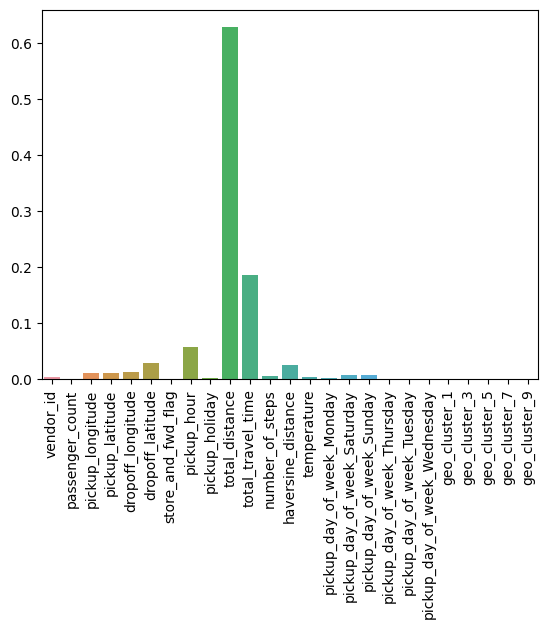

In [199]:
feature_names = [i for i in X_train.columns]
bar = sns.barplot(y=gdboost.feature_importances_, x=feature_names)
bar.tick_params(axis='x',labelrotation=90)

In [200]:
y_valid = []
for i in y_valid_log:
    y_valid.append(np.exp(i) - 1) 
  
y_valid_pred = []
for i in y_valid_pred_gdb:
    y_valid_pred.append(np.exp(i) - 1)
    
print('MeAE valid =',round(metrics.median_absolute_error(y_valid, y_valid_pred)/60,1))

MeAE valid = 1.8


In [201]:
test_data = pd.read_csv("data/test_data.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

In [202]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = clear_null_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [208]:
y_test_pred = gdboost.predict(X_test_scaled)

y_test_predict = []
for i in y_test_pred:
    y_test_predict.append(np.exp(i) - 1)

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

In [209]:
import xgboost as xgb

In [210]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

In [211]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93575	valid-rmse:1.93569
[20]	train-rmse:0.78507	valid-rmse:0.78592
[30]	train-rmse:0.47892	valid-rmse:0.48093
[40]	train-rmse:0.42050	valid-rmse:0.42312
[50]	train-rmse:0.40890	valid-rmse:0.41187
[60]	train-rmse:0.40421	valid-rmse:0.40761
[70]	train-rmse:0.40130	valid-rmse:0.40512
[80]	train-rmse:0.39910	valid-rmse:0.40326
[90]	train-rmse:0.39715	valid-rmse:0.40159
[100]	train-rmse:0.39544	valid-rmse:0.40017
[110]	train-rmse:0.39415	valid-rmse:0.39928
[120]	train-rmse:0.39297	valid-rmse:0.39832
[130]	train-rmse:0.39152	valid-rmse:0.39718
[140]	train-rmse:0.39054	valid-rmse:0.39654
[150]	train-rmse:0.38924	valid-rmse:0.39552
[160]	train-rmse:0.38870	valid-rmse:0.39516
[170]	train-rmse:0.38805	valid-rmse:0.39483
[180]	train-rmse:0.38737	valid-rmse:0.39443
[190]	train-rmse:0.38648	valid-rmse:0.39376
[200]	train-rmse:0.38582	valid-rmse:0.39334
[210]	train-rmse:0.38518	valid-rmse:0.39316
[220]	train-rmse:0.38468	valid-rmse:0.39291

In [212]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39078


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

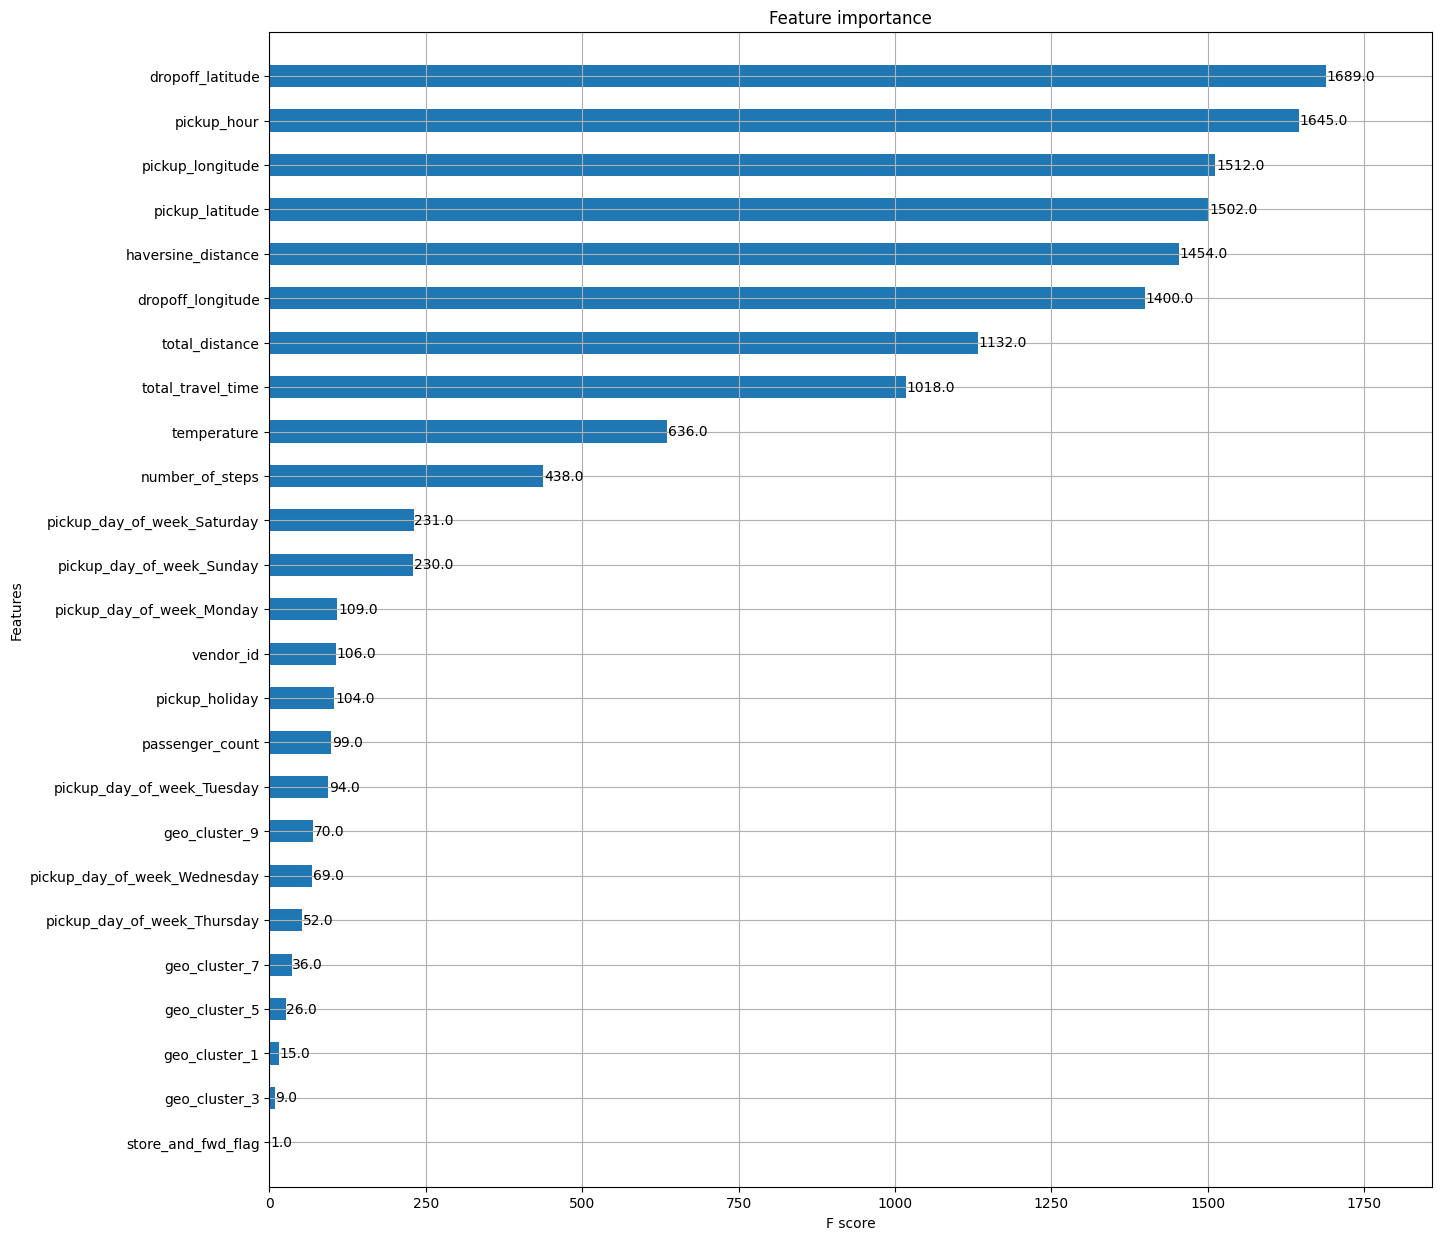

In [215]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)